Imports


In [18]:
!pip install wandb thop torchvision matplotlib


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader
from thop import profile
import wandb


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [21]:
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms


In [22]:
wandb.login()

wandb.init(
    entity="ikamboj-919-iit-jodhpur",
    project="updated_cnn_cifar10",
    name="cnn-class-aligned"
)


In [23]:
class CIFAR10Custom(Dataset):
    def __init__(self, train=True, transform=None):
        self.dataset = datasets.CIFAR10(
            root="./data",
            train=train,
            download=True
        )
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [24]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(
        (0.5, 0.5, 0.5),
        (0.5, 0.5, 0.5)
    )
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.5, 0.5, 0.5),
        (0.5, 0.5, 0.5)
    )
])


In [25]:
train_dataset = CIFAR10Custom(
    train=True,
    transform=train_transform
)

test_dataset = CIFAR10Custom(
    train=False,
    transform=test_transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False
)

print("Train batches:", len(train_loader))
print("Test batches:", len(test_loader))


Train batches: 391
Test batches: 79


In [26]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [27]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model


CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [28]:
dummy_input = torch.randn(1, 3, 32, 32).to(device)

macs, params = profile(
    model,
    inputs=(dummy_input,),
    verbose=False
)

print("FLOPs (MACs):", macs)
print("Total Parameters:", params)


FLOPs (MACs): 6654464.0
Total Parameters: 1070794.0


In [29]:
def plot_gradient_flow(named_parameters, epoch, log_to_wandb=True):
    """Visualize and log gradient flow across all layers"""
    ave_grads = []
    layers = []
    grad_dict = {}

    for name, param in named_parameters:
        if param.requires_grad and param.grad is not None:
            layers.append(name)
            grad_value = param.grad.abs().mean().cpu().item()
            ave_grads.append(grad_value)
            grad_dict[f"gradient/{name}"] = grad_value

    # Plot locally
    plt.figure(figsize=(12, 6))
    plt.plot(ave_grads, marker='o')
    plt.xticks(range(len(layers)), layers, rotation=90)
    plt.xlabel("Layers")
    plt.ylabel("Average Gradient Magnitude")
    plt.title(f"Gradient Flow - Epoch {epoch}")
    plt.grid(True)
    plt.tight_layout()

    # Log to Wandb
    if log_to_wandb:
        wandb.log(grad_dict)
        wandb.log({f"gradient_flow_plot": wandb.Image(plt)})

    plt.show()
    plt.close()


def plot_weight_update_flow(named_parameters, prev_params, epoch, log_to_wandb=True):
    """Visualize and log weight update flow across all layers"""
    weight_updates = []
    layers = []
    update_dict = {}

    for name, param in named_parameters:
        if param.requires_grad and name in prev_params:
            layers.append(name)
            # Calculate weight update magnitude
            weight_update = (param.data - prev_params[name]).abs().mean().cpu().item()
            weight_updates.append(weight_update)
            update_dict[f"weight_update/{name}"] = weight_update

    # Plot locally
    if len(weight_updates) > 0:
        plt.figure(figsize=(12, 6))
        plt.plot(weight_updates, marker='o', color='green')
        plt.xticks(range(len(layers)), layers, rotation=90)
        plt.xlabel("Layers")
        plt.ylabel("Average Weight Update Magnitude")
        plt.title(f"Weight Update Flow - Epoch {epoch}")
        plt.grid(True)
        plt.tight_layout()

        # Log to Wandb
        if log_to_wandb:
            wandb.log(update_dict)
            wandb.log({f"weight_update_flow_plot": wandb.Image(plt)})

        plt.show()
        plt.close()

    # Store current parameters for next epoch
    current_params = {}
    for name, param in named_parameters:
        if param.requires_grad:
            current_params[name] = param.data.clone()

    return current_params


Epoch [1/25]  Loss: 622.1425  Acc: 41.92%


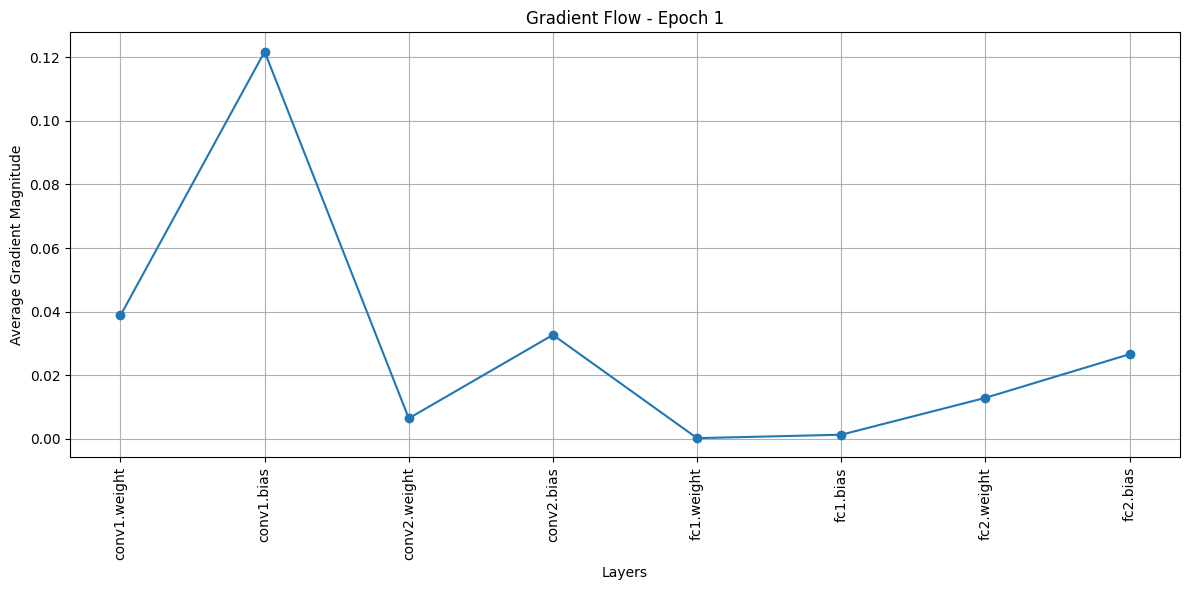

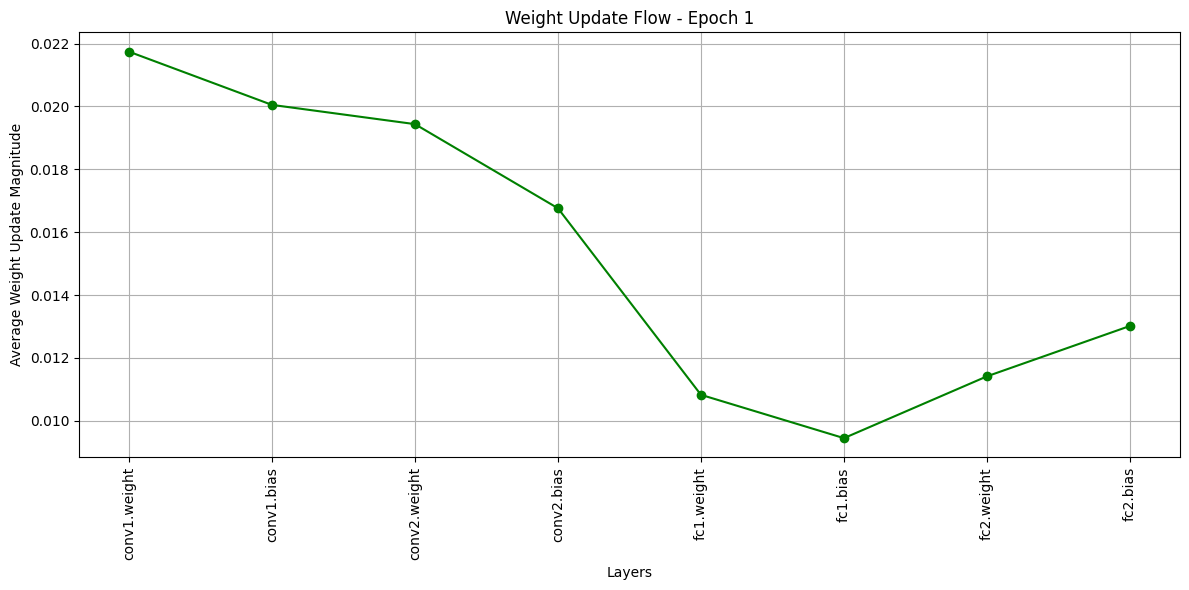

Epoch [2/25]  Loss: 499.9441  Acc: 53.87%


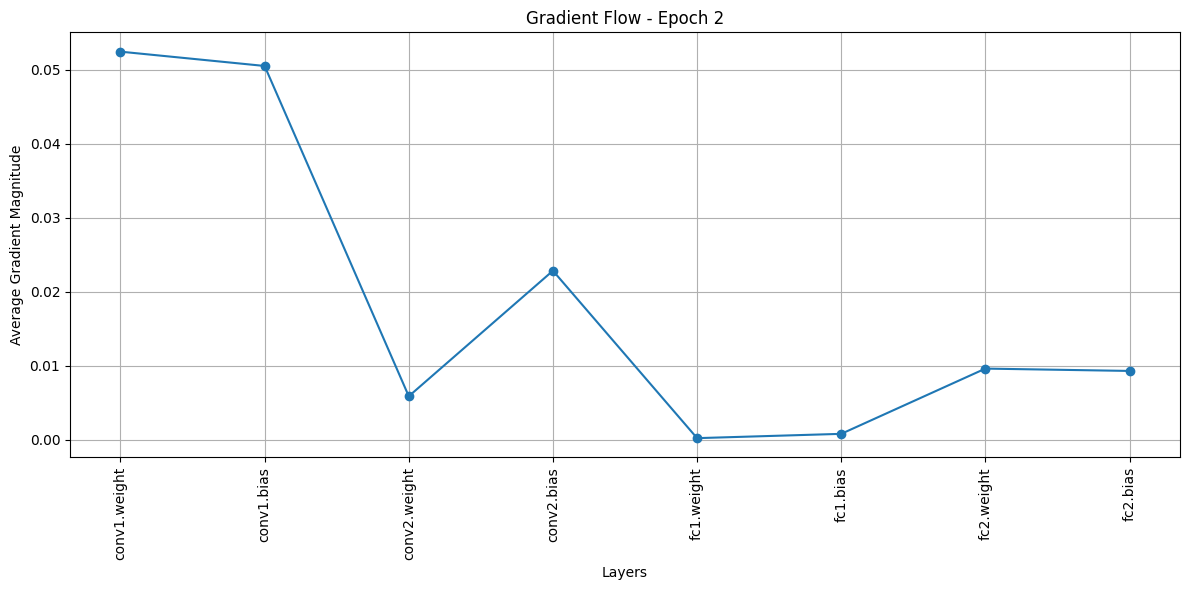

Epoch [3/25]  Loss: 438.0171  Acc: 60.08%


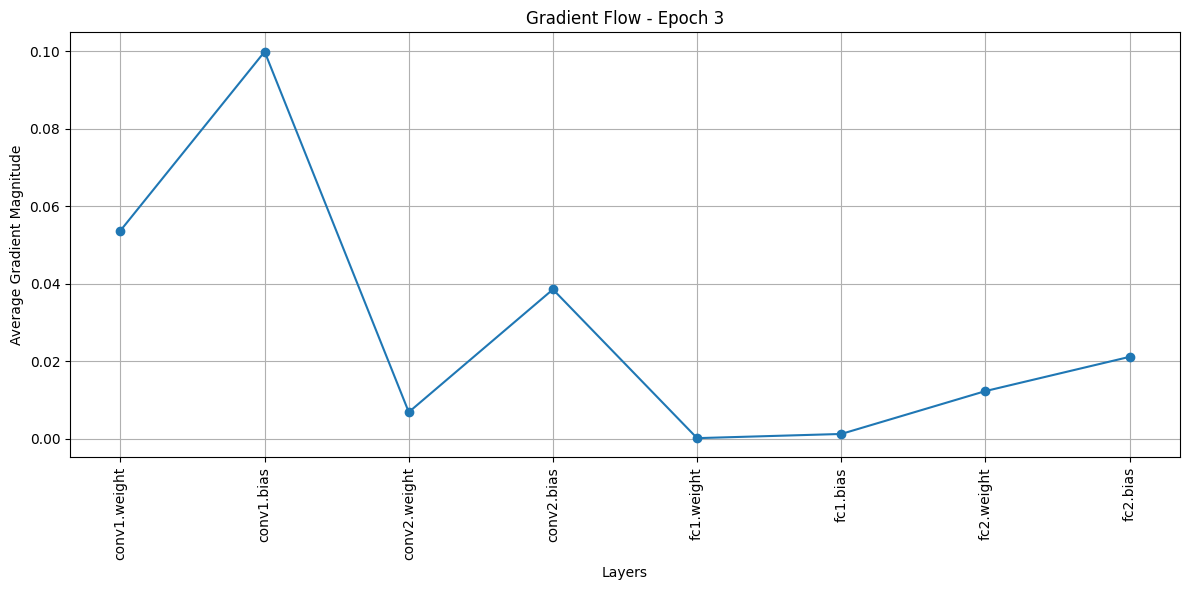

Epoch [4/25]  Loss: 399.8996  Acc: 63.67%


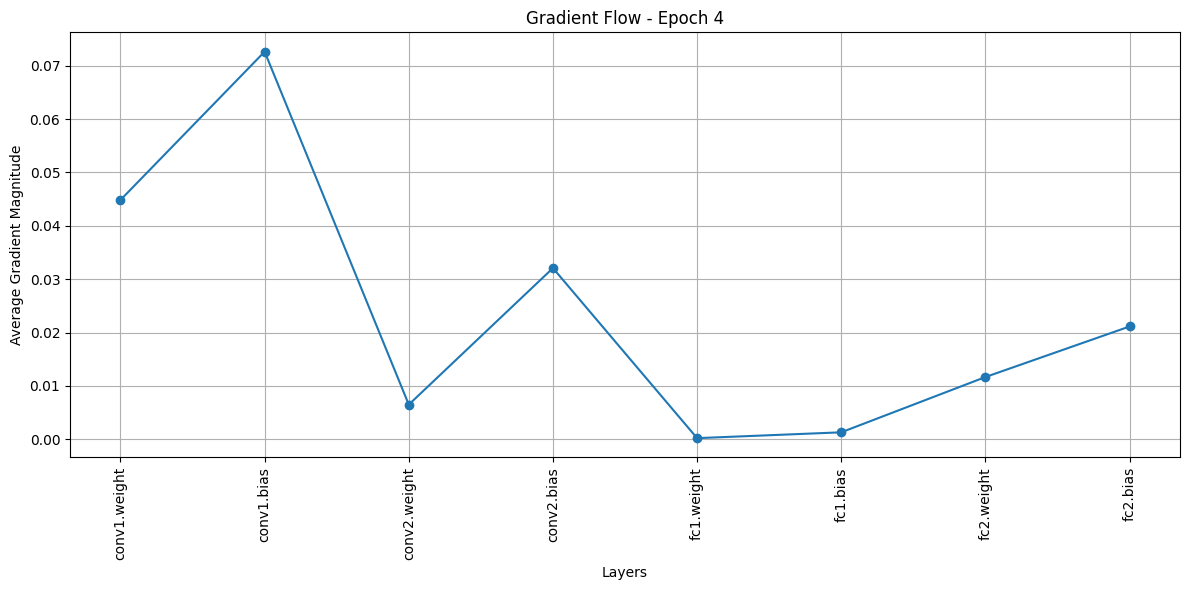

Epoch [5/25]  Loss: 370.4013  Acc: 66.62%


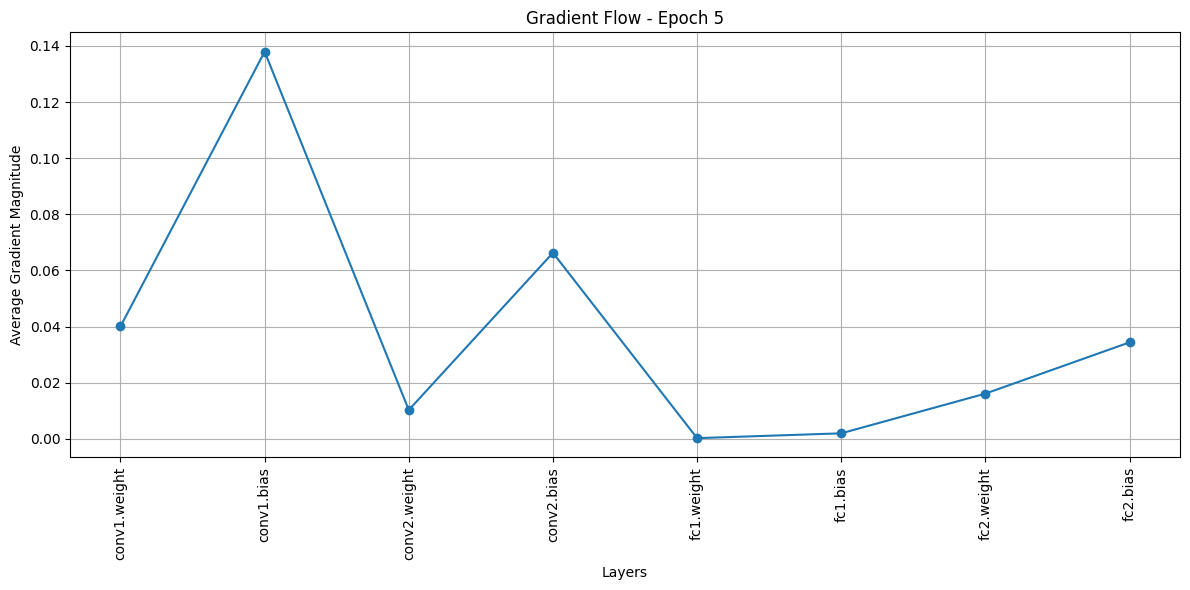

Epoch [6/25]  Loss: 352.0765  Acc: 68.22%


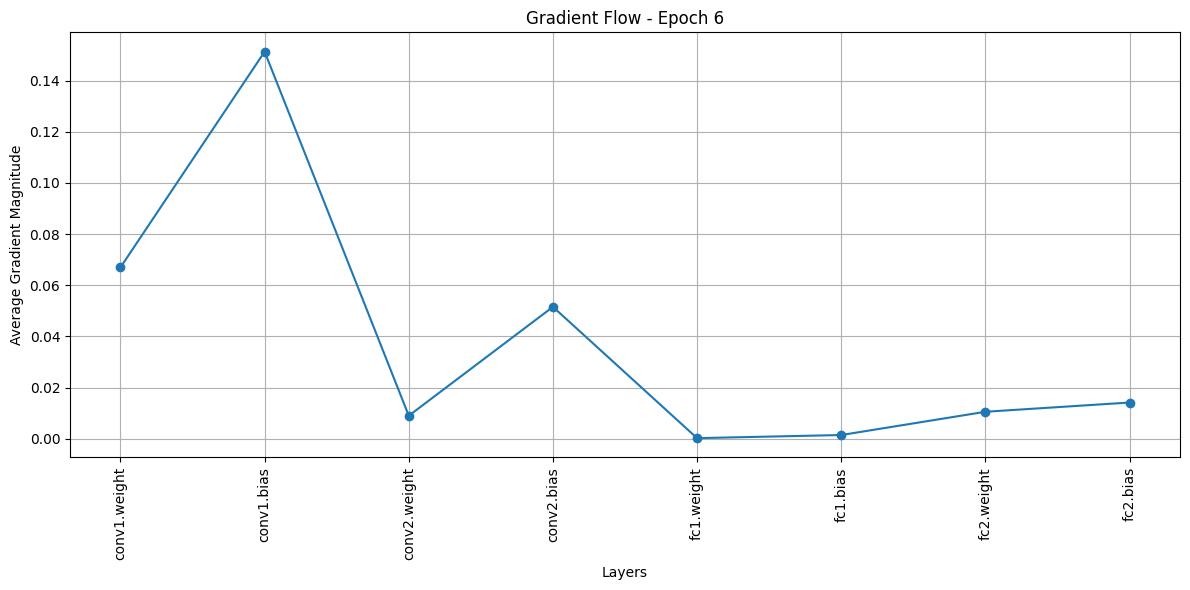

Epoch [7/25]  Loss: 334.4744  Acc: 70.06%


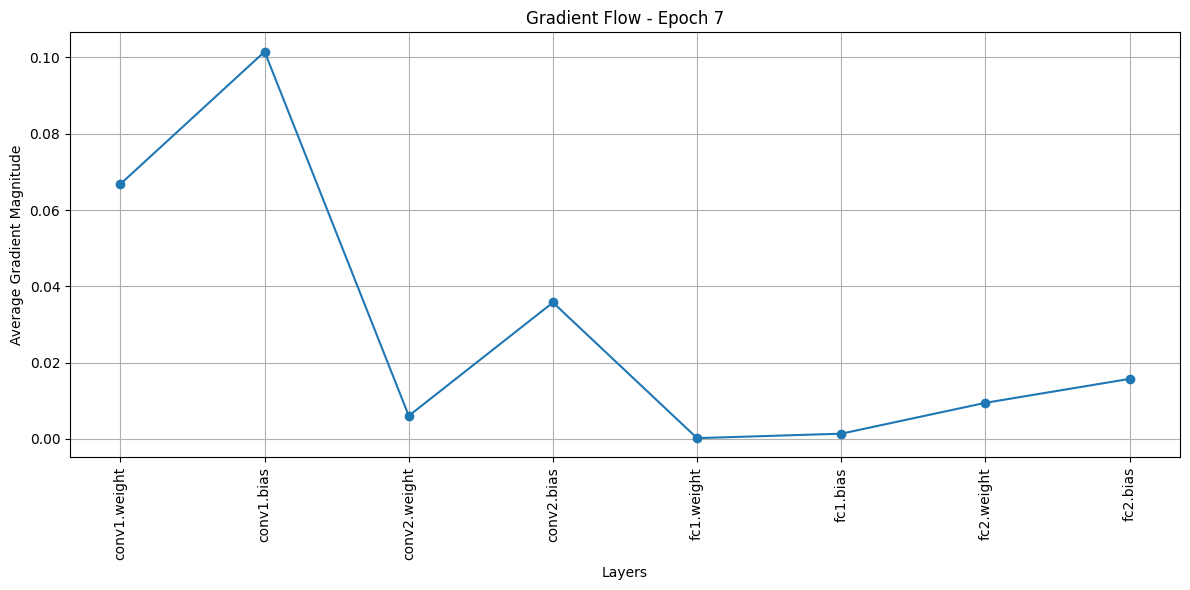

Epoch [8/25]  Loss: 321.6846  Acc: 71.00%


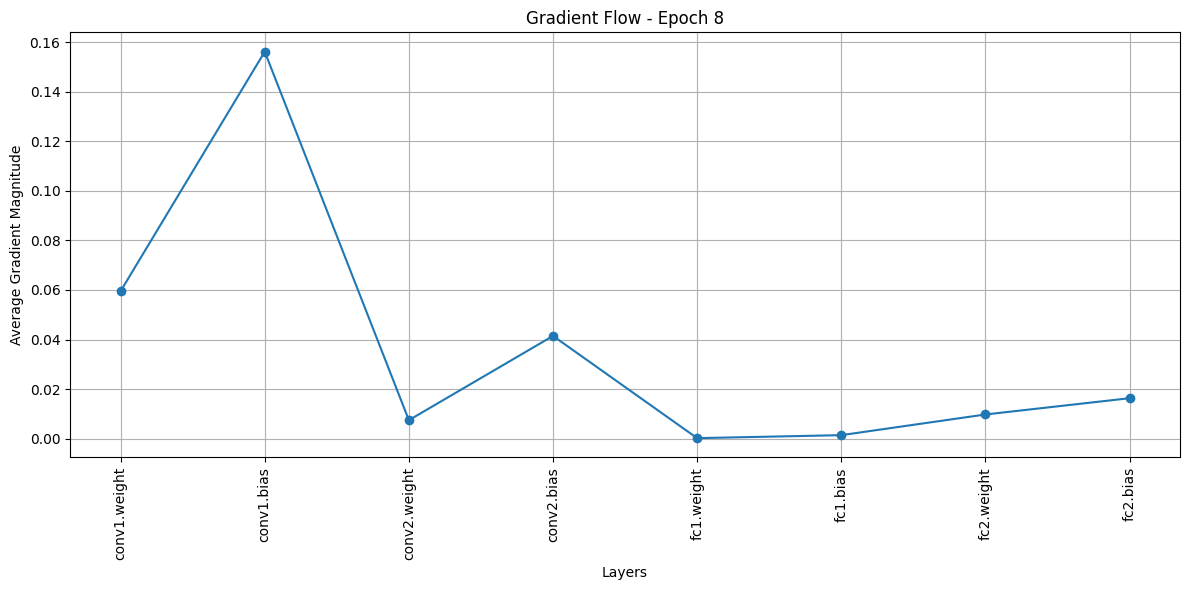

Epoch [9/25]  Loss: 309.1876  Acc: 72.12%


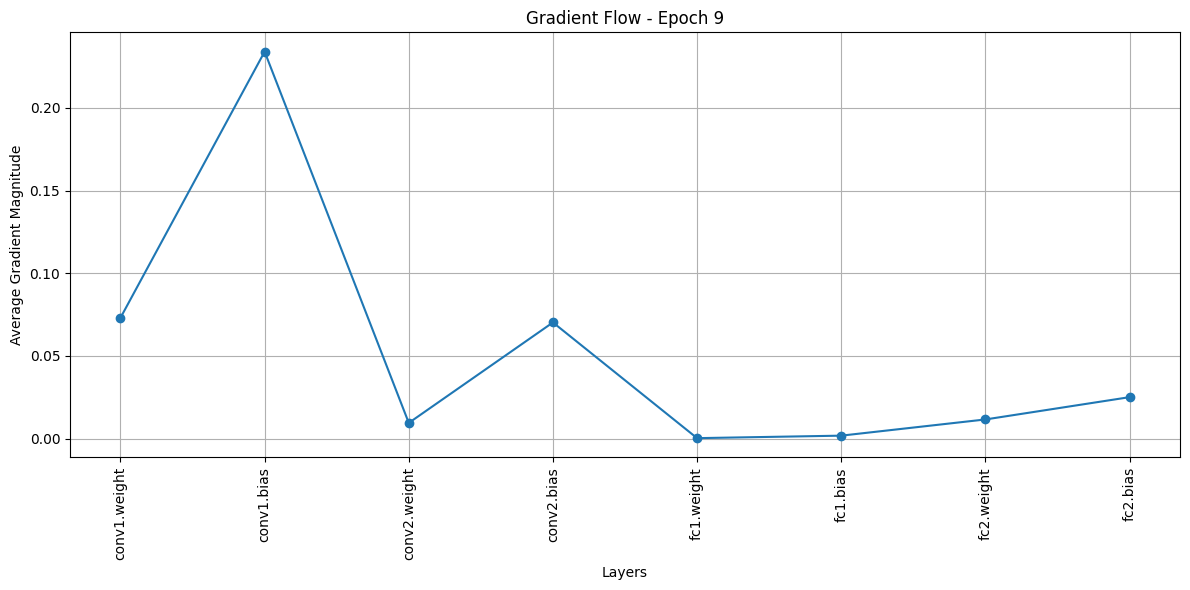

Epoch [10/25]  Loss: 299.0565  Acc: 72.94%


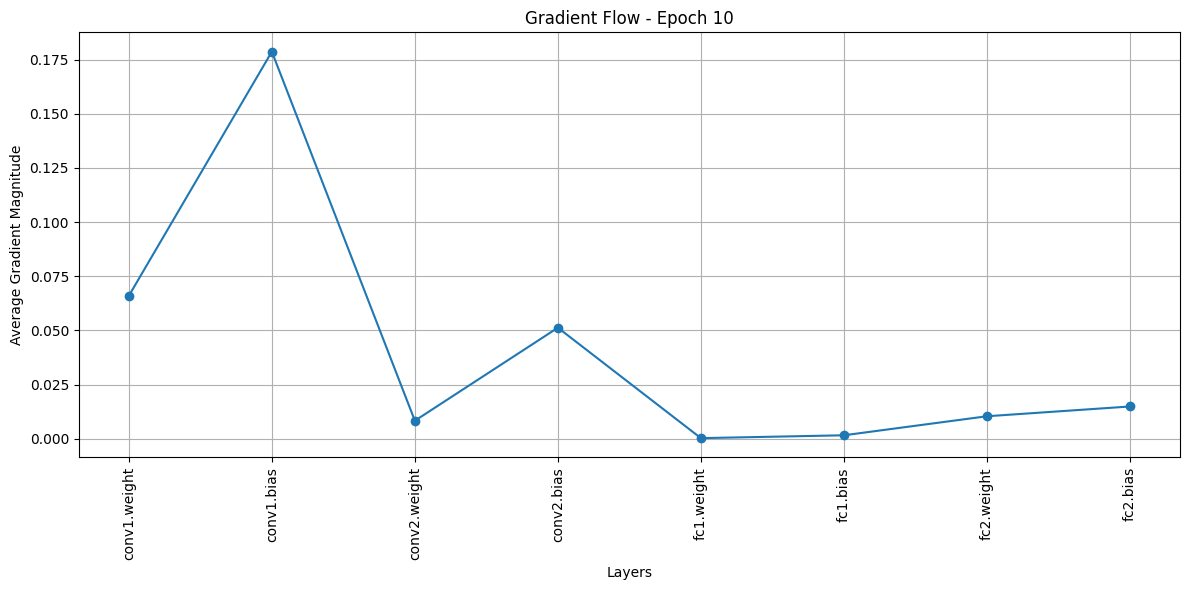

Epoch [11/25]  Loss: 290.8709  Acc: 73.97%


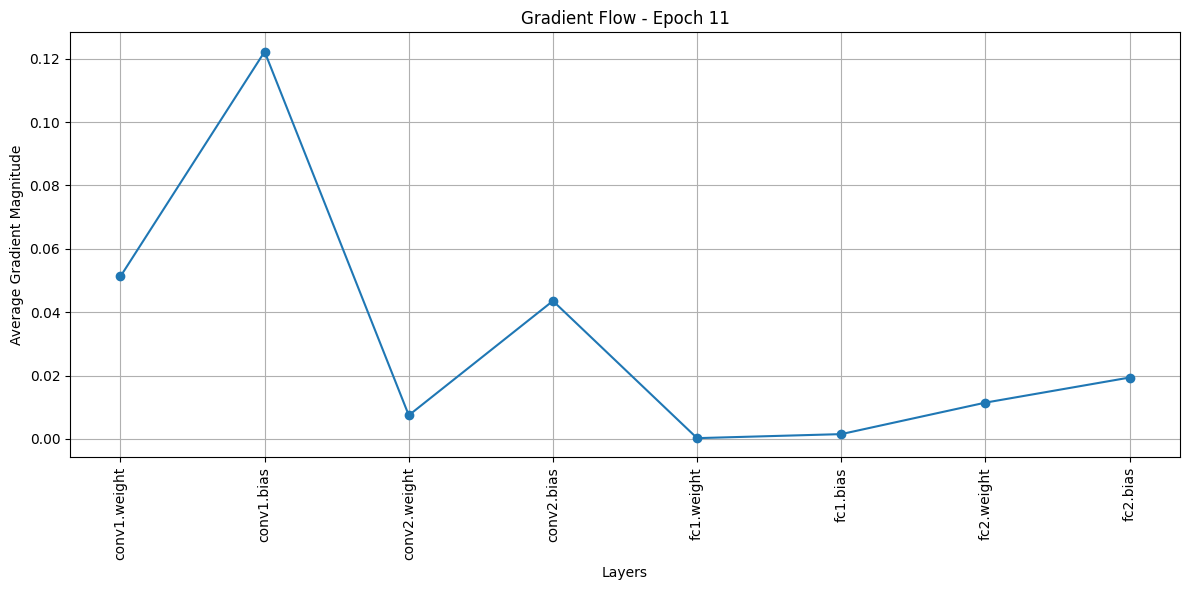

Epoch [12/25]  Loss: 280.9520  Acc: 74.76%


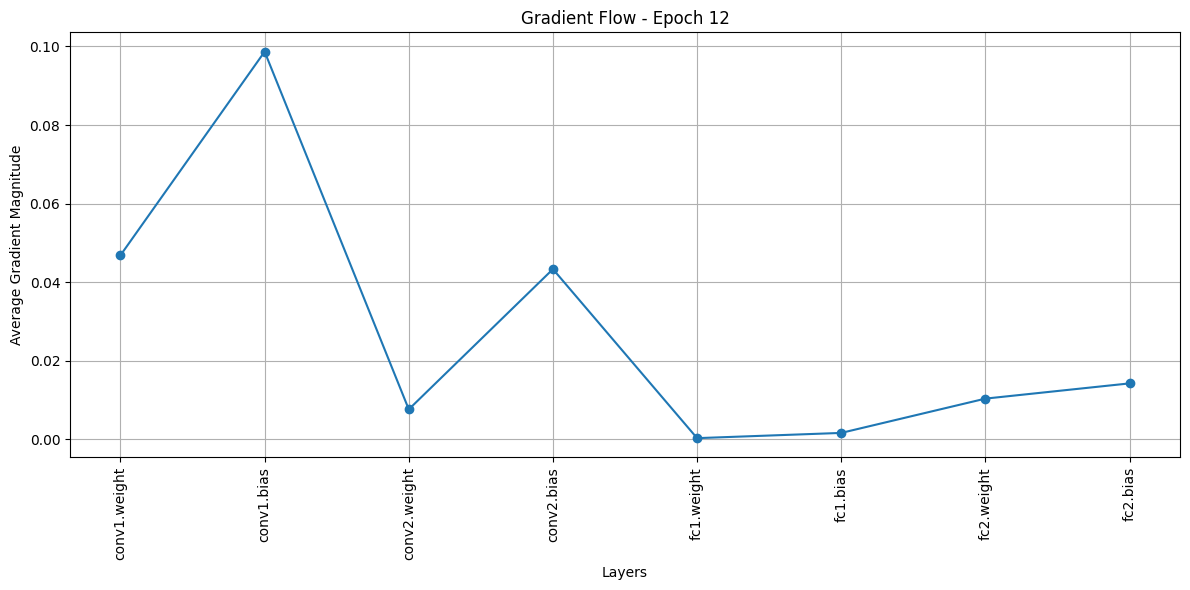

Epoch [13/25]  Loss: 275.8883  Acc: 75.12%


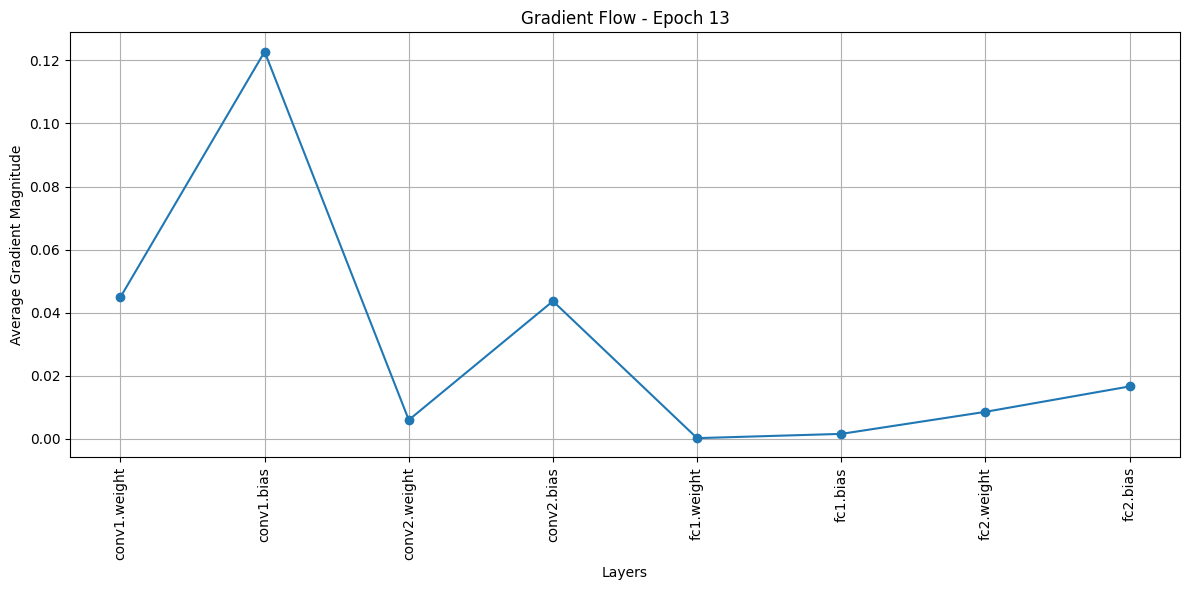

Epoch [14/25]  Loss: 266.7863  Acc: 76.17%


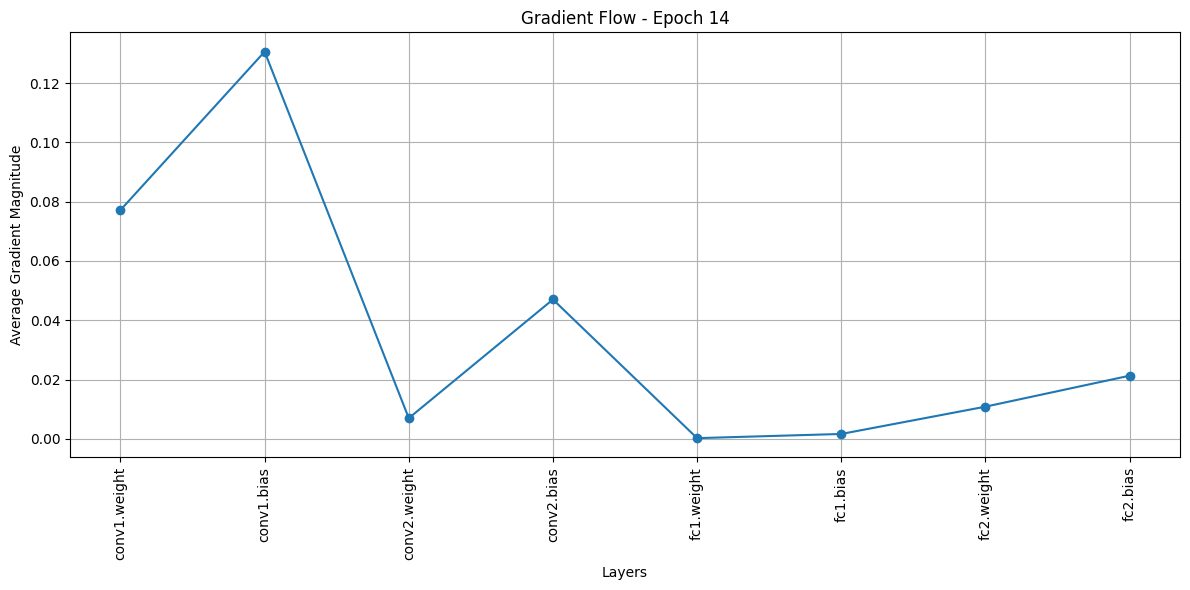

Epoch [15/25]  Loss: 262.1261  Acc: 76.60%


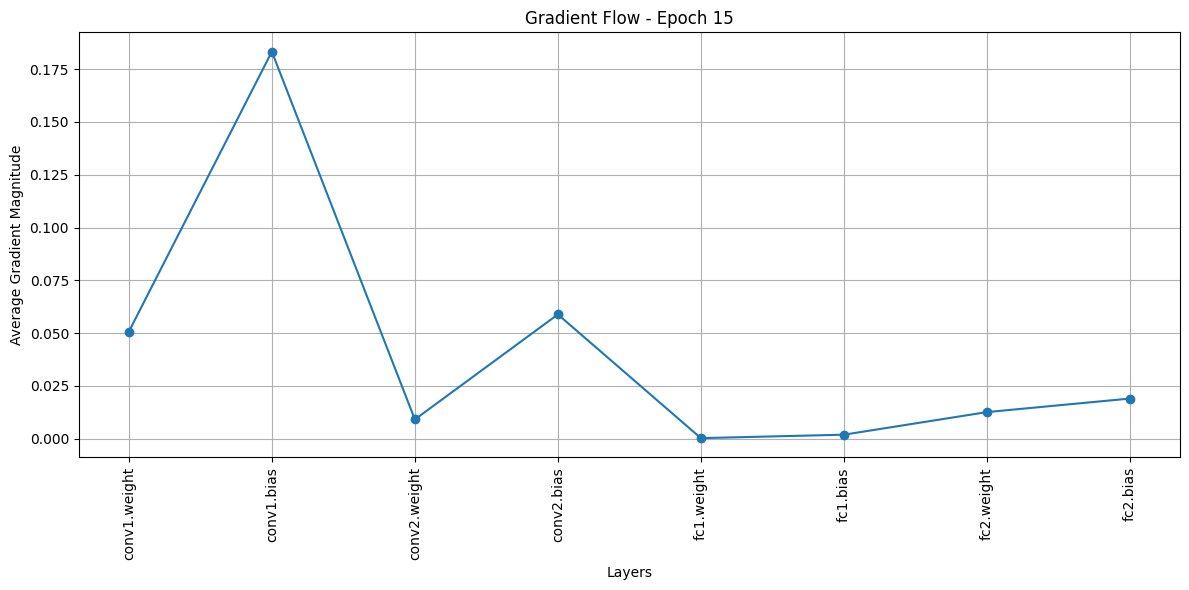

Epoch [16/25]  Loss: 255.9490  Acc: 76.97%


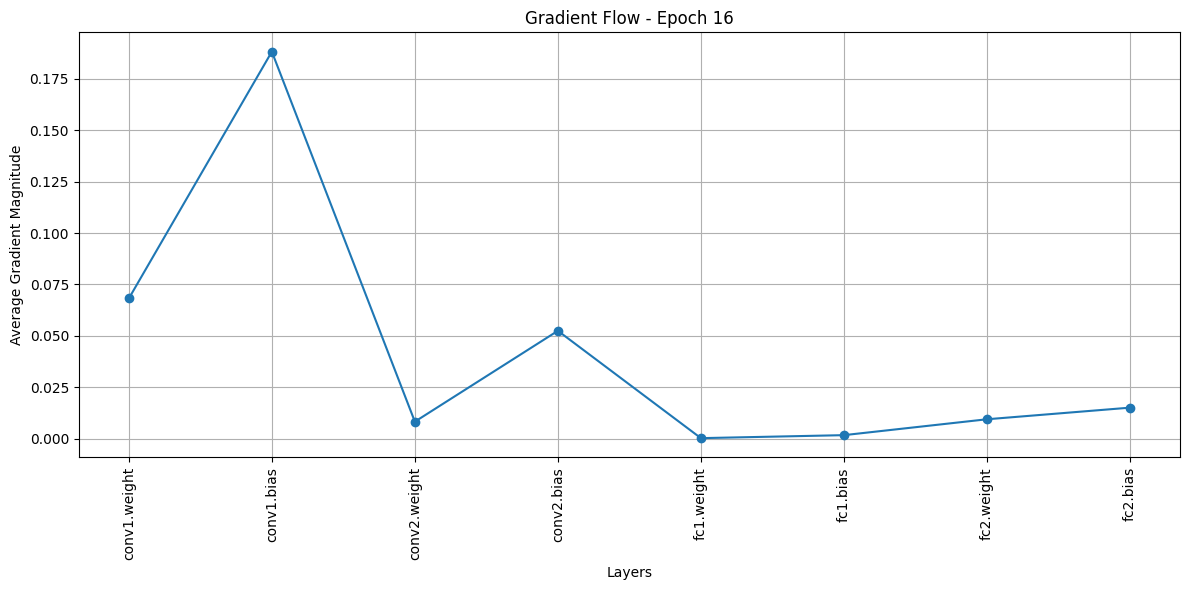

Epoch [17/25]  Loss: 251.0628  Acc: 77.54%


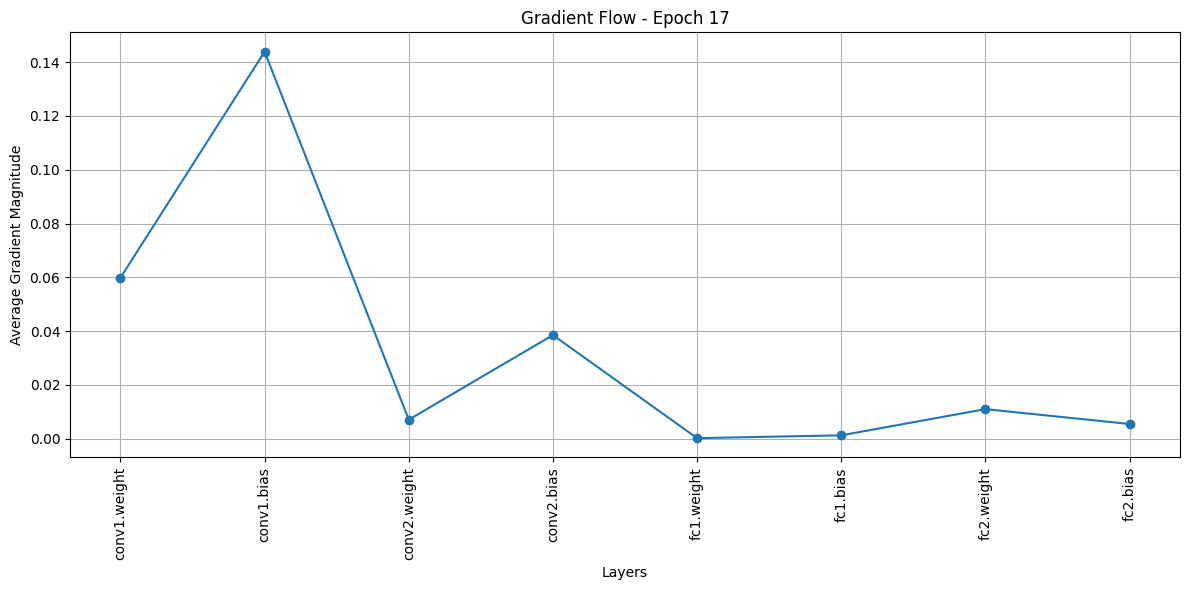

Epoch [18/25]  Loss: 246.7482  Acc: 77.86%


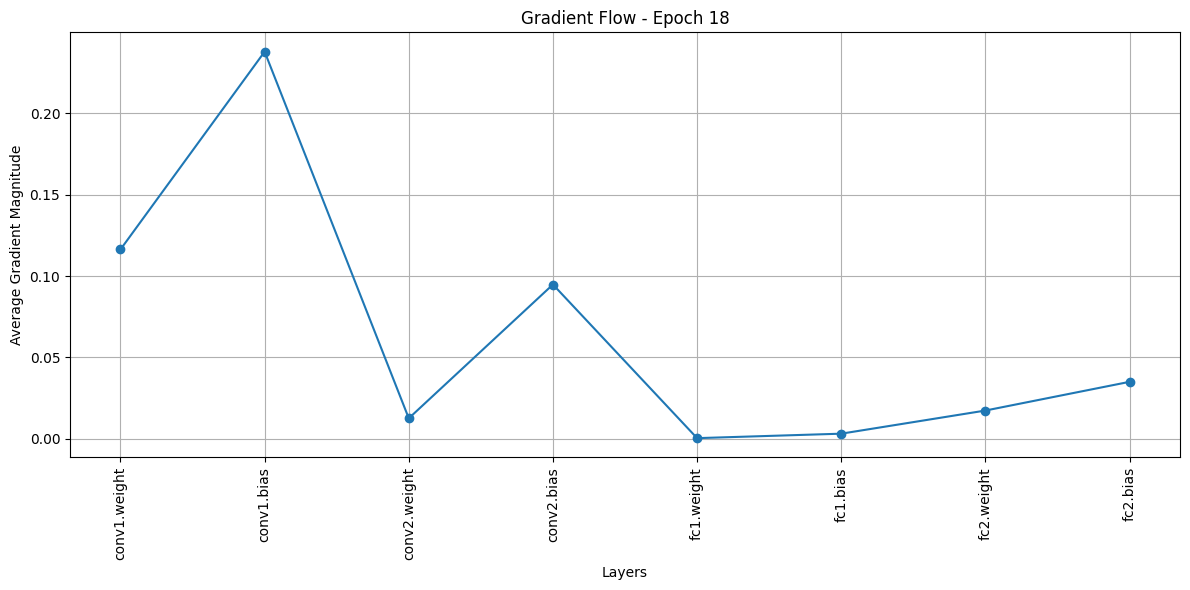

Epoch [19/25]  Loss: 242.3475  Acc: 78.37%


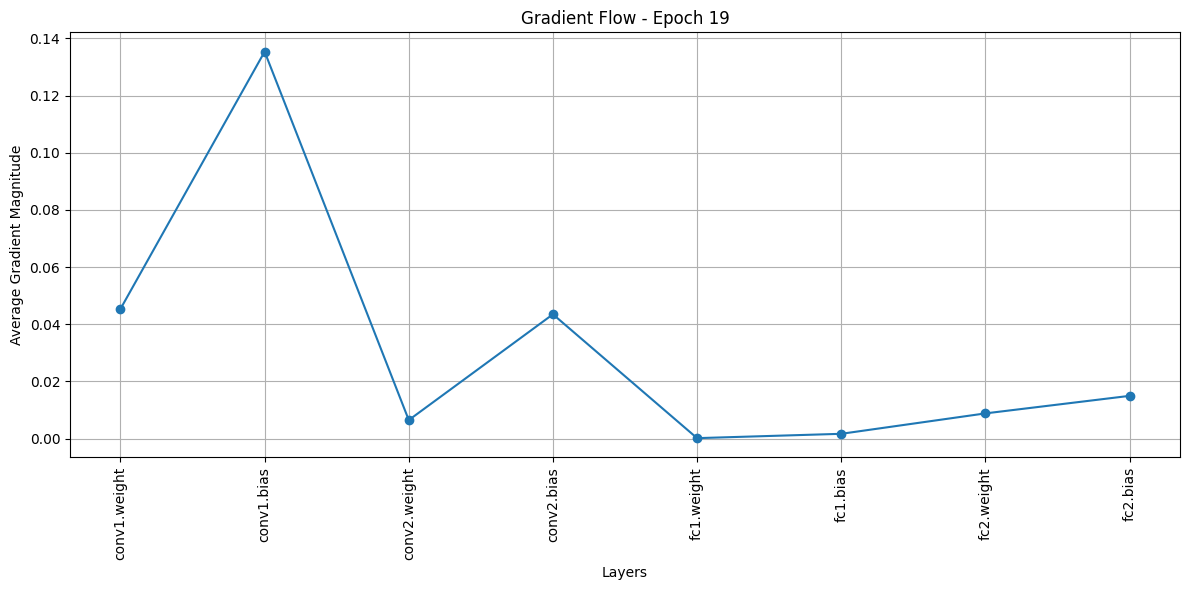

Epoch [20/25]  Loss: 239.7891  Acc: 78.46%


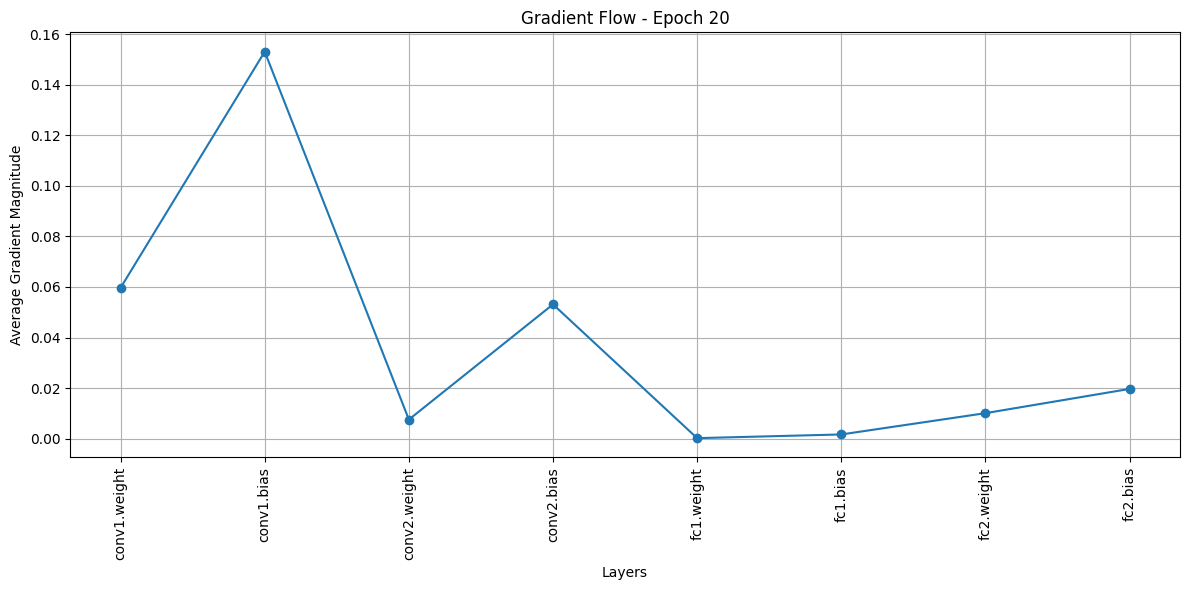

Epoch [21/25]  Loss: 232.9514  Acc: 79.10%


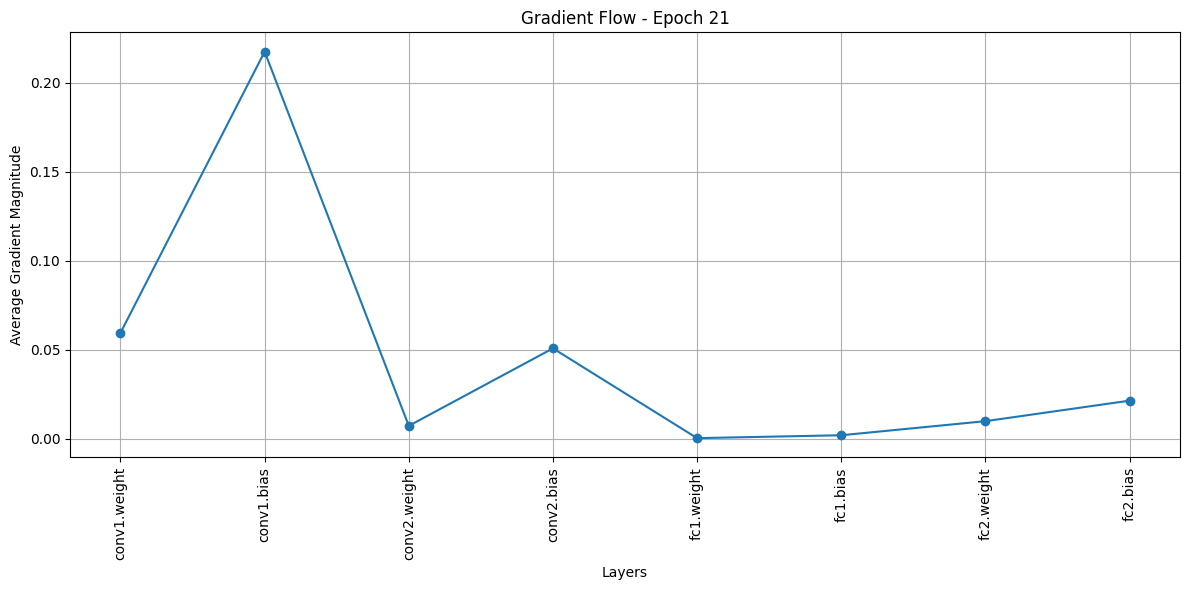

Epoch [22/25]  Loss: 230.7850  Acc: 79.28%


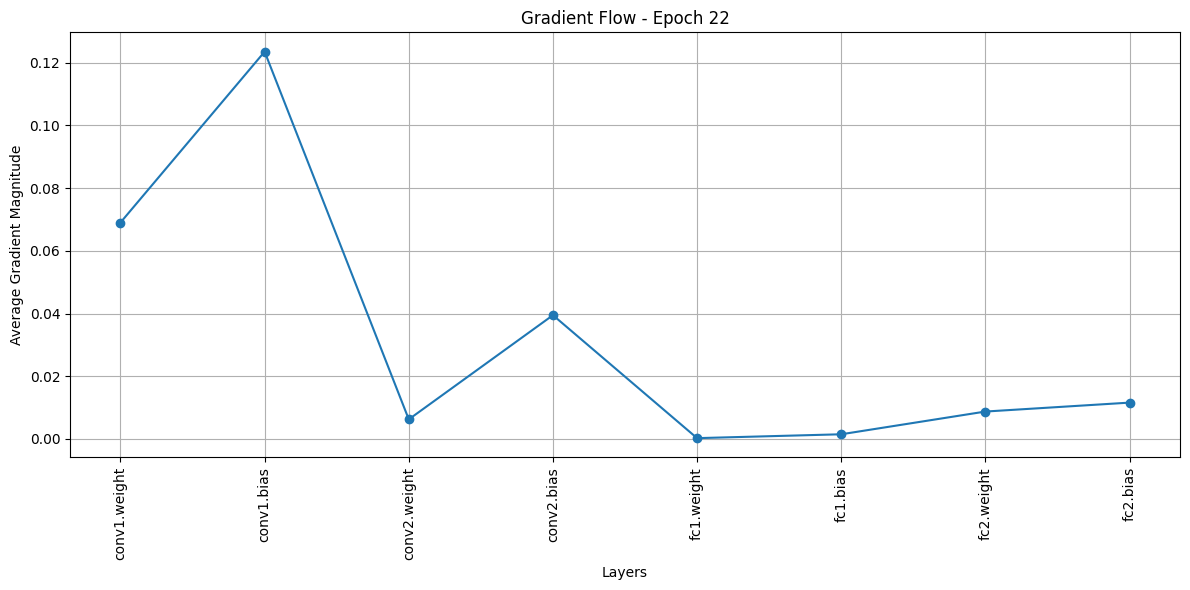

Epoch [23/25]  Loss: 225.1094  Acc: 79.79%


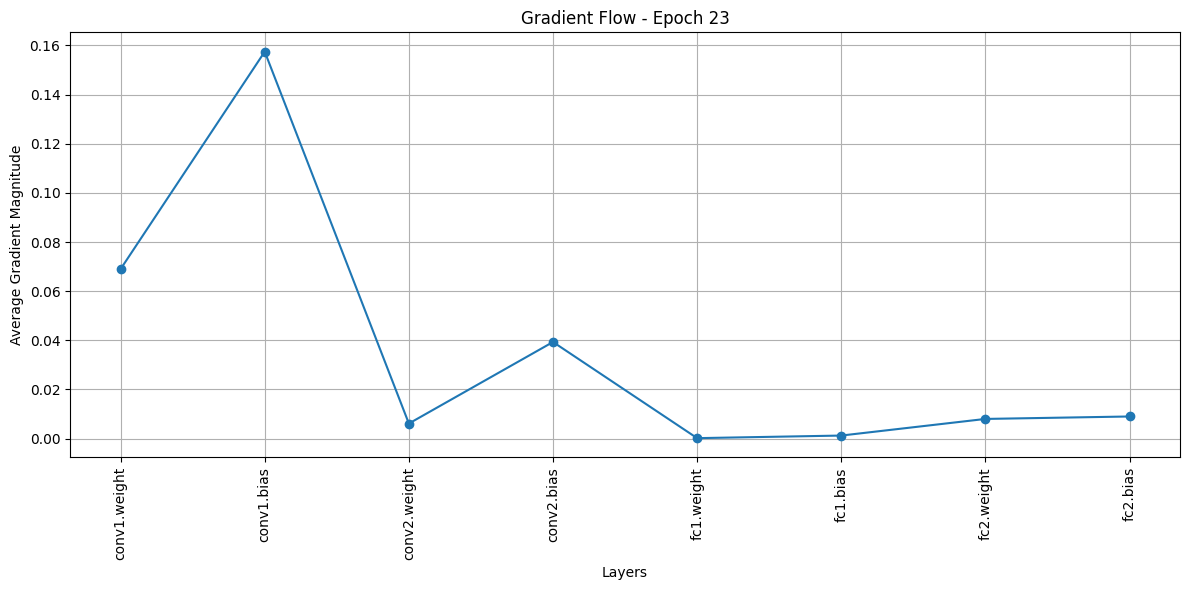

Epoch [24/25]  Loss: 224.5065  Acc: 79.80%


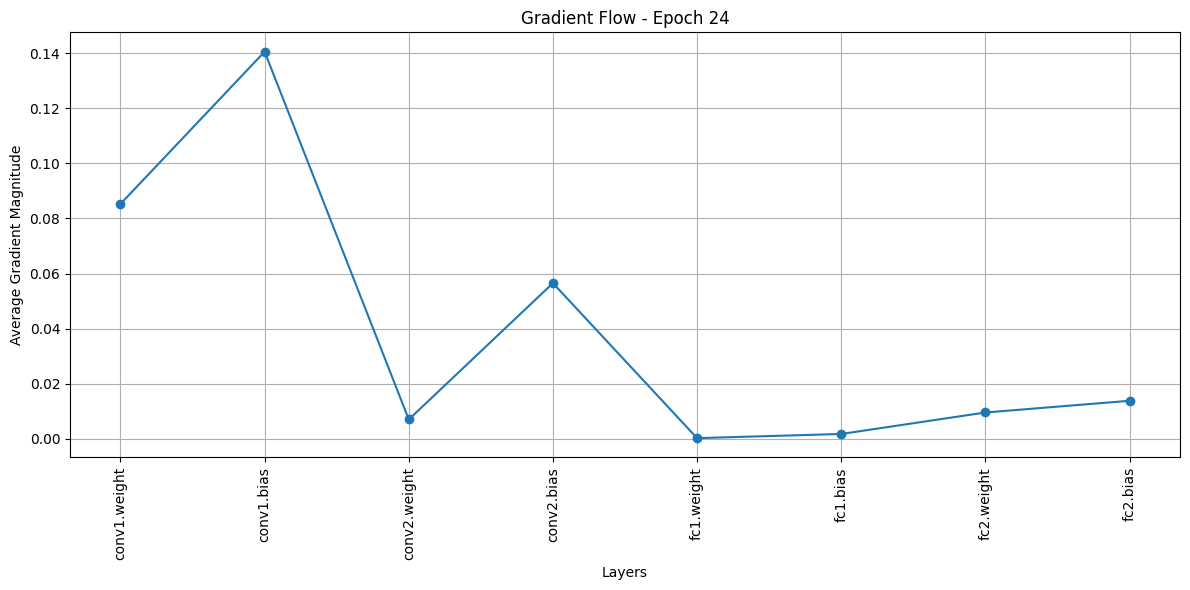

Epoch [25/25]  Loss: 222.2333  Acc: 80.03%


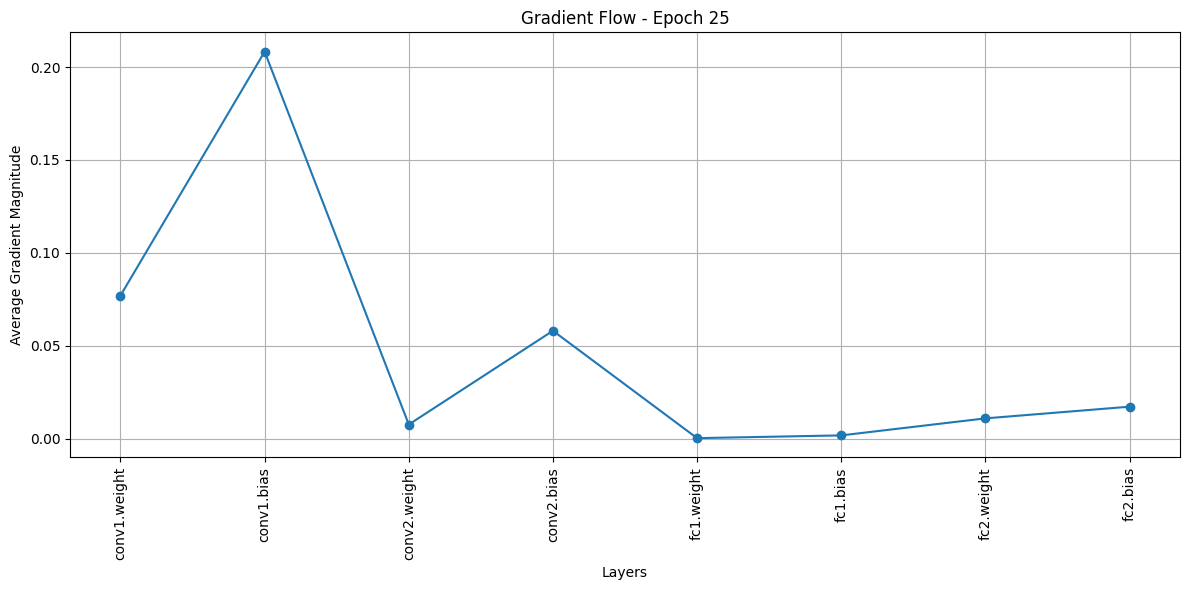

In [30]:
epochs = 25


# Store initial parameters for weight update flow
prev_params = {
    name: param.data.clone()
    for name, param in model.named_parameters()
    if param.requires_grad
}


# Store initial parameters for weight update tracking
prev_params = {}
for name, param in model.named_parameters():
    if param.requires_grad:
        prev_params[name] = param.data.clone()

for epoch in range(epochs):
    model.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total

    print(f"Epoch [{epoch+1}/25]  Loss: {running_loss:.4f}  Acc: {acc:.2f}%")

    wandb.log({
        "epoch": epoch + 1,
        "train_loss": running_loss,
        "train_accuracy": acc
    })

    plot_gradient_flow(model.named_parameters(), epoch + 1)
    prev_params = plot_weight_update_flow(
        model.named_parameters(),
        prev_params,
        epoch + 1
    )



In [31]:
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print("Test Accuracy:", test_accuracy)

wandb.log({"test_accuracy": test_accuracy})


Test Accuracy: 78.17


In [32]:
wandb.finish()


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
gradient/conv1.bias,▄▁▃▂▄▅▃▅█▆▄▃▄▄▆▆▄█▄▅▇▄▅▄▇
gradient/conv1.weight,▁▂▂▂▁▄▄▃▄▃▂▂▂▄▂▄▃█▂▃▃▄▄▅▄
gradient/conv2.bias,▂▁▃▂▅▄▂▃▆▄▃▃▃▃▅▄▃█▃▄▄▃▃▄▄
gradient/conv2.weight,▂▁▂▂▆▄▁▃▅▄▃▃▁▂▄▄▂█▂▃▂▁▁▂▃
gradient/fc1.bias,▂▁▃▃▅▃▃▃▄▃▃▃▃▄▄▄▃█▄▄▄▃▂▄▄
gradient/fc1.weight,▂▂▂▃▅▃▂▂▃▄▄▄▂▃▅▃▄█▁▂▂▃▁▃▃
gradient/fc2.bias,▆▂▅▅█▃▃▄▆▃▄▃▄▅▄▃▁█▃▄▅▂▂▃▄
gradient/fc2.weight,▅▂▄▄▇▃▂▂▄▃▄▃▁▃▄▂▃█▂▃▂▂▁▂▃
test_accuracy,▁
+10,...
